In [1]:
import network as nw
import numpy as np 
from scipy.sparse import csr_matrix
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(10)

In [2]:
#collecting data from csv file
data = np.genfromtxt("connections.csv", delimiter=",")
#matrix dimension
N = int(np.max(data)) + 1
#generating the sparse matrix from data
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
#making the network undirected
A = A + A.T
A_w = A
#removing multilinks
A = 1*(A > 0)

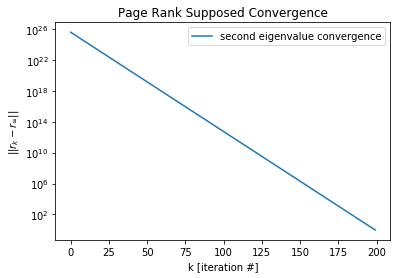

In [3]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
d = 1 / nw.get_degrees(A)
M = A * sp.sparse.diags(d[:, 0])
v = nw.get_two_highest_eigenvalues(M)
v2 = v[1]

plt.title("Page Rank Supposed Convergence")
ind = np.arange(200)
ref = (0.85*np.abs(v2))**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["second eigenvalue convergence"])


In [4]:
#from the previous graph the error is reduced by a factor o 1e15 
#after more or less 125 iterations
num_iter = 125
p = nw.page_rank_power_iteration(A, iter_num = num_iter)

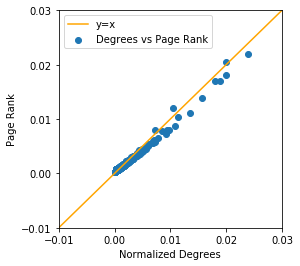

In [5]:
d = nw.get_degrees(A)
plt.figure(figsize=(4,4))
plt.locator_params(nbins=5)
plt.axis([-0.01, 0.03, -0.01, 0.03])
plt.xlabel("Normalized Degrees")
plt.ylabel("Page Rank")
plt.scatter(d/np.sum(d), p)
plt.plot(np.linspace(-0.01, 0.3, 100), np.linspace(-0.01, 0.3, 100), c = "orange")
plt.legend(["y=x", "Degrees vs Page Rank"])


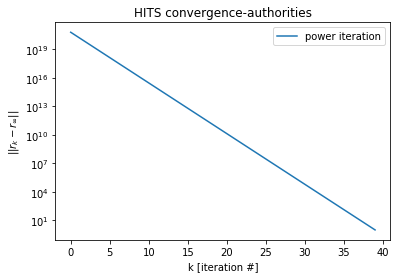

In [6]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
v = nw.get_two_highest_eigenvalues(A*A.T)

plt.figure()
plt.title("HITS convergence-authorities")
ind = np.arange(40)
ref = np.abs(v[1]/v[0])**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["power iteration", "second eigenvalue"])


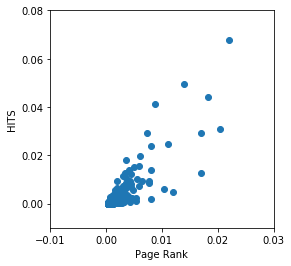

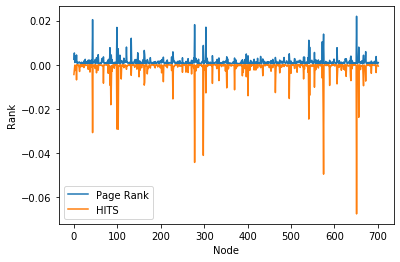

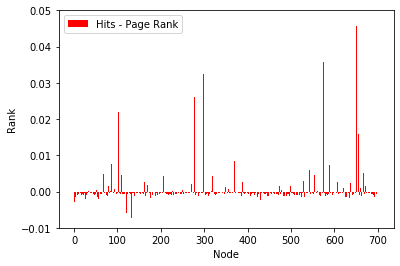

In [7]:
#i see that 40 iterations reduce the error by a reasonable amount
num_iter = 40
r = nw.hits_power_iteration(A_w, iter_num=num_iter)

plt.figure(figsize=(4,4))
#plt.axis("equal")
plt.locator_params(nbins=5)
plt.axis([-0.01, 0.03, -0.01, 0.08])
plt.xlabel("Page Rank")
plt.ylabel("HITS")
plt.scatter(p, r/np.sum(r))

plt.figure()
plt.plot(np.arange(N), p.reshape(-1))
plt.plot(np.arange(N), -r.reshape(-1)/np.sum(r))
plt.legend(["Page Rank", "HITS"])
plt.xlabel("Node")
plt.ylabel("Rank")

plt.figure()
plt.bar(np.arange(N), r.reshape(-1)/np.sum(r) - p.reshape(-1), color="red")
plt.ylim([-0.01, 0.05])
plt.xlabel("Node")
plt.ylabel("Rank")
plt.legend(["Hits - Page Rank"])

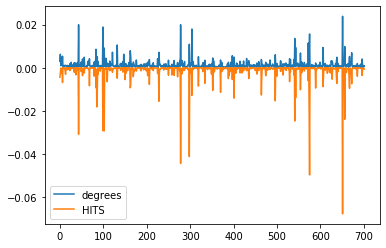

In [8]:
#plotting page rank against degrees
plt.plot(d/np.sum(d))
plt.plot(-r/np.sum(r))
plt.legend(["degrees", "HITS"])

In [9]:
#array that contains the name of each character so it's index is it's id
characters_id = []

#reading from file
with open("nodes.csv", "r") as fp:
    for line in fp:
        #for each line get name and id
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [10]:
#index that would sort from less ranked to most ranked with hits and normal degrees
ids_r = np.argsort(r, axis = 0)
ids_d = np.argsort(d, axis = 0)

#ranking based on the rank difference obtained with the two ranking methods
ids_rd = np.argsort(r-d, axis = 0)

#positions in the ranking the one with the highest rank is assigned position 0
positions = np.arange(N)[::-1]

#getting the position of each character with both rankings
position_d = positions[np.argsort(ids_d, axis = 0)]
position_r = positions[np.argsort(ids_r, axis = 0)]

#points = position
#scores = 
#increment in position with HITS rank compared with the other
delta_pos = position_d - position_r
ids_delta = np.argsort(delta_pos, axis = 0)
characters_r = [characters_id[i[0]] for i in ids_r[::-1]]
characters_d = [characters_id[i[0]] for i in ids_d[::-1]]
characters_rd = [characters_id[i[0]] for i in ids_delta[::-1]]
pos_d = [position_d[i[0]][0] for i in ids_delta[::-1]]
pos_r = [position_r[i[0]][0] for i in ids_delta[::-1]]
pd_dict = {
    "HITS":characters_r, 
    "deg":characters_d
}
pd_imp_dict = {
    "character_improvement":characters_rd,
    "improvement": np.sort(delta_pos, axis = 0)[::-1,0],
    "d_pos": pos_d,
    "r_pos": pos_r

}
df = pd.DataFrame(pd_dict)
df_imp = pd.DataFrame(pd_imp_dict)

In [11]:
df_imp[(df_imp["r_pos"] < 10) | (df_imp["d_pos"] < 10)]

,character_improvement,improvement,d_pos,r_pos
316,Sandor Clegane,9,18,9
320,Cersei Lannister,8,13,5
325,Joffrey Baratheon,5,8,3
331,Sansa Stark,4,5,1
336,Tywin Lannister,2,10,8
339,Tyrion Lannister,0,0,0
343,Jaime Lannister,-1,1,2
350,Robb Stark,-1,6,7
355,Arya Stark,-2,2,4
358,Catelyn Stark,-3,3,6


In [12]:
df.head()

,HITS,deg
0,Tyrion Lannister,Tyrion Lannister
1,Sansa Stark,Jaime Lannister
2,Jaime Lannister,Arya Stark
3,Joffrey Baratheon,Catelyn Stark
4,Arya Stark,Jon Snow


In [13]:
#function used to print all of the characters in a community
def print_community(community, character_id, weights=None):
    #if hard division is used
    if weights is None:
        print([character_id[idx] for idx in community])
    #if every node can belong to multiple communities
    else:
        #finding the probability of being in the community where the character belongs
        maxes = np.max(weights, axis = 1)
        #ordering from the less likely community to the most likely
        ordered_comm = np.argsort(weights, axis = 1)
        #ordering from the less to the most likely node in that community
        ids = np.argsort(maxes)
        
        #formatting the string to be printed
        f = lambda x: "{0} {1:.2f}, second community {2} with prob {3:.2f}".format(
            character_id[community[x]],
            maxes[x],
            ordered_comm[x][-2],
            weights[x][ordered_comm[x][-2]]
        )
        characters = map(f, ids)
        for char in characters:
            print(char)

Text(0, 0.5, 'Eigenvalues')

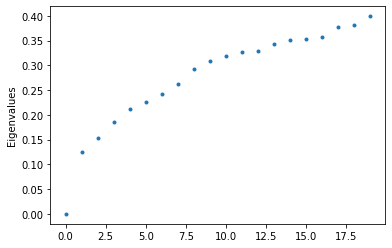

In [14]:
#getting the normalized laplacian L
D = nw.get_D_matrix(A)
L = sp.sparse.identity(N) - D*A*D

#getting the eigenvectors of L
eig_val, eig_vec = np.linalg.eigh(L.toarray())

#normlizing the eigenvectors
eig_vec = D * eig_vec
eig_vec = eig_vec / np.linalg.norm(eig_vec, axis = 0).reshape(1, -1)

#plotting the 20 smallest eigenvalue in order to find out where the eigengap is large
plt.plot(eig_val[0:20], linestyle="None", marker = ".")
plt.ylabel("Eigenvalues")

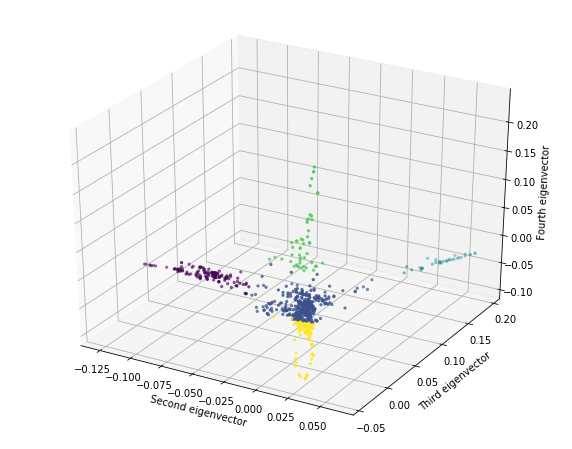

In [15]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D

#dividing the data in 5 clusters
km = KMeans(n_clusters = 5).fit_predict(eig_vec[:,1:4])

#3d representation of the 3 vectors after fiedler's
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Second eigenvector")
ax.set_ylabel("Third eigenvector")
ax.set_zlabel("Fourth eigenvector")
ax.scatter(eig_vec[:, 1], eig_vec[:, 2], eig_vec[:, 3], linestyle="None", marker = ".", c = km)

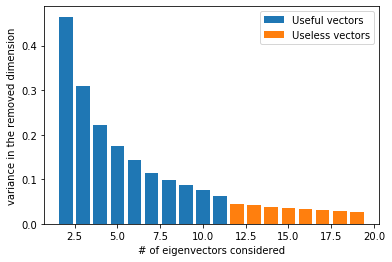

In [16]:
from sklearn.decomposition import PCA

#temp variables
info_given = []
n_max = 20

#the idea is that at one point the variance lost by the data by removing one dimension 
#will be small meaning that using more eigenvectors would be useless

#using a number of eigenvectors that goes from 2 to n_max
for i in range(2, n_max):
    #reducing the dimensionality of the data by 1
    pca = PCA(i - 1).fit(eig_vec[:,1:(1+i)])
    
    #getting the variance provided by the last dimension
    info_given.append(1-np.sum(pca.explained_variance_ratio_))

#there is always a strange step at a certaing point
#using that as the point where to stop
info_given = np.array(info_given)
lim = np.argmax(info_given < 0.05)
plt.bar(range(2, lim + 2), info_given[0:lim])
plt.bar(range(lim + 2, n_max), info_given[lim:n_max-2])
plt.ylabel("variance in the removed dimension")
plt.xlabel("# of eigenvectors considered")
plt.legend(["Useful vectors", "Useless vectors"])

100%|██████████| 48/48 [00:05<00:00,  9.43it/s]


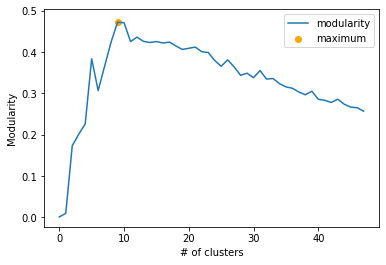

In [17]:
from tqdm import tqdm
modularity = []
#max number of clusters
kmax = 50

#trying n_clusters from 2 to kmax-1
for i in tqdm(range(2, kmax)):
    #getting the clustering division according to kmeans
    km = KMeans(n_clusters = i).fit_predict(eig_vec[:,1:(lim+1)])
    
    #calculating modularity
    modularity.append(nw.get_modularity(A, km))
    
plt.plot(modularity)
plt.xlabel("# of clusters")
plt.ylabel("Modularity")

#getting the bes number of clusters
amax = np.argmax(np.array(modularity)) + 2
plt.scatter(amax - 2, modularity[amax - 2], c = "orange")
plt.legend(["modularity", "maximum"])

#fitting kmeans with the best number of clusters
km = KMeans(n_clusters = amax).fit_predict(eig_vec[:, 1:(lim+1)])

In [18]:
#viewing the identified communities
i = 1
indexes = np.arange(N)
print_community(indexes[km == i], characters_id)

['Aggo', 'Barristan Selmy', 'Belwas', 'Cleon', 'Daario Naharis', 'Daenerys Targaryen', 'Eraz', 'Eroeh', 'Ghael', 'Grazdan', 'Groleo', 'Illyrio Mopatis', 'Irri', 'Jhiqui', 'Jogos Nhai', 'Jorah Mormont', 'Khal Drogo', 'Khal Temmo', 'Khaznys', 'Ko Jhogo', 'Kraznys', 'Mago', 'Mero', 'Mirri Maz Duur', 'Missandei', 'Oznak', 'Prendahl', 'Pyat Pree', 'Quaithe', 'Rakharo', 'Rhaego', 'Sallor', 'Scarb', 'Willem Darry', 'Xaro Xhoan Daxos']


100%|██████████| 48/48 [00:05<00:00,  9.10it/s]


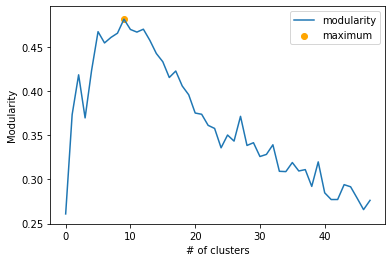

In [19]:
#same as before but with Gaussian Mixture instead of kmeans
#this should give better results as Gaussian Mixtures allow also elliptical clusters
modularity = []
kmax = 50
for i in tqdm(range(2, kmax)):
    km = GaussianMixture(n_components = i).fit_predict(eig_vec[:,1:(lim+1)])
    modularity.append(nw.get_modularity(A, km))
    
plt.plot(modularity)
plt.xlabel("# of clusters")
plt.ylabel("Modularity")
amax = np.argmax(np.array(modularity)) + 2
plt.scatter(amax - 2, modularity[amax - 2], c = "orange")
plt.legend(["modularity", "maximum"])

gm = GaussianMixture(n_components = amax).fit(eig_vec[:, 1:(lim+1)])
#getting the probabilities for each community
probas = gm.predict_proba(eig_vec[:,1:(lim+1)])
#getting the community
classes = np.argmax(probas, axis = 1)

In [20]:
#checking first and second community for each member in a community
i = 9
indexes = np.arange(N).reshape(N)
print_community(indexes[classes == i], characters_id, probas[classes==i, :])

Dyah 0.75, second community 7 with prob 0.25
Endrew Tarth 0.98, second community 7 with prob 0.02
Benjen Stark 1.00, second community 7 with prob 0.00
Jarman Buckwell 1.00, second community 7 with prob 0.00
Emmett 1.00, second community 7 with prob 0.00
Jaremy Rykker 1.00, second community 7 with prob 0.00
Ryswell 1.00, second community 3 with prob 0.00
Talla 1.00, second community 7 with prob 0.00
Denys Mallister 1.00, second community 7 with prob 0.00
Othell Yarwyck 1.00, second community 7 with prob 0.00
Owen Norrey 1.00, second community 6 with prob 0.00
Hareth 1.00, second community 7 with prob 0.00
Septon Cellador 1.00, second community 7 with prob 0.00
Bowen Marsh 1.00, second community 7 with prob 0.00
Donal Noye 1.00, second community 7 with prob 0.00
Three-Finger Hobb 1.00, second community 7 with prob 0.00
Jeor Mormont 1.00, second community 6 with prob 0.00
Aemon Targaryen 1.00, second community 7 with prob 0.00
Clydas 1.00, second community 7 with prob 0.00
Tim Tangletongu

In [21]:
#communities seen as armies for later
Daenerys = indexes[classes == 0]
Lannisters = indexes[classes == 1]
Robb = indexes[classes == 6]
Free_folks = indexes[classes == 7]
Stannis = indexes[classes == 8]
Night_watch = indexes[classes == 9]

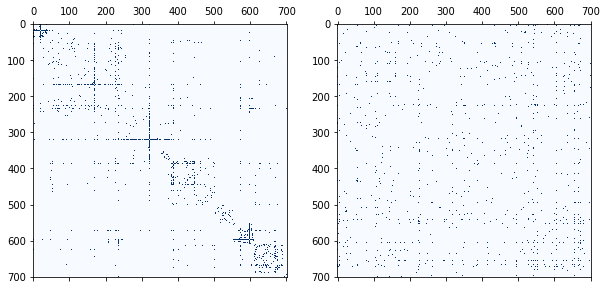

In [22]:
#plotting the matrix ordered in communities
classes_ids = np.argsort(classes, axis = 0)
A_temp = A[classes_ids, :][:, classes_ids]
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].matshow(A_temp.toarray(), cmap = "Blues")
axs[1].matshow(A.toarray(), cmap = "Blues")

In [23]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

#ignoring sparse efficiency warning because in this case it is not more efficient to use a lil_matrix
warnings.simplefilter('ignore',SparseEfficiencyWarning)

#getting a dictionary of armies
armies = {
    "Daenerys": Daenerys,
    "Stannis": Stannis,
    "Lannisters": Lannisters,
    "Robb": Robb,
    "Free Folks": Free_folks,
    "Night's watch": Night_watch
}

def check_army_robustness(A, army, ax, name):

    A1 = A[army.reshape(-1), :][:, army.reshape(-1)]
    N = A1.shape[0]
    
    #getting parameters from random and hubs removal
    random_removal, attack_removal = nw.check_robustness(A1)
    
    #getting the GC dimensions
    random = np.array(random_removal[0])/N
    attack = np.array(attack_removal[0])/N

    #getting the breaking points
    #since inhomogeneity ratio isn't working on most communities because they are too small
    #we say that an army breaks if the biggest component contains less than the 5% 
    #of the original army
    break_random = np.argmax(random < 0.05)
    break_attack = np.argmax(attack < 0.05)

    ax.plot(np.linspace(0, 1, N), random)
    ax.plot(np.linspace(0, 1, N), attack)
    ax.plot(np.linspace(0, 1, N),np.arange(N, 0, -1)/N)
    ax.vlines(break_random/N, 0, 0.1, colors="darkblue")
    ax.vlines(break_attack/N, 0, 0.1, colors="red")
    ax.set_xlabel("f")
    ax.set_title(f"Robustness for the army of {name}")
    ax.legend([
        "Random removal", 
        "Hubs removal", 
        "# of nodes", 
    ])
    ax.set_ylabel("$P_\infty(f)/P_\infty(0)$")


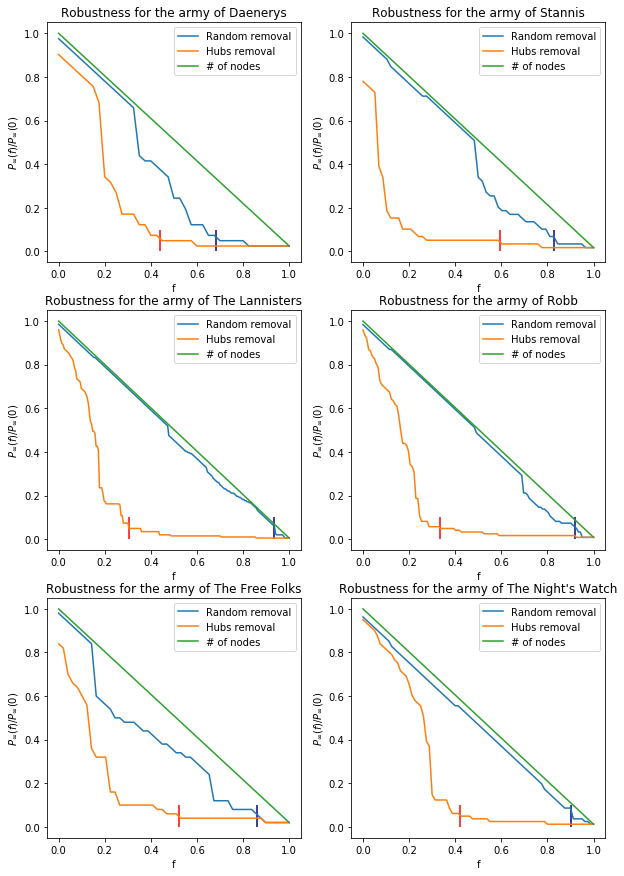

In [24]:
fig, axs = plt.subplots(3,2, figsize=(10,15))
#plotting the robustness of the armies
check_army_robustness(A, armies["Daenerys"], axs[0, 0], "Daenerys")
check_army_robustness(A, armies["Stannis"], axs[0, 1], "Stannis")
check_army_robustness(A, armies["Lannisters"], axs[1, 0], "The Lannisters")
check_army_robustness(A, armies["Robb"], axs[1, 1], "Robb")
check_army_robustness(A, armies["Free Folks"], axs[2, 0], "The Free Folks")
check_army_robustness(A, armies["Night's watch"], axs[2, 1], "The Night's Watch")

In [25]:
#finding the communities thanks to spectral clustering
f = nw.spectral_clustering_reordering

communities, separators = nw.divide_in_communities(A, f, conductance_lim=0.25)
print(len(communities))

15


In [26]:
#getting the created communities
i = 1
print(f'community index = {communities[i]["path"]}')
print(f"community")
chara = communities[i]["indexes"]
chara.sort()
print_community(chara, characters_id)
print(f"borderline character = {characters_id[communities[i]['border']]}")

community index = 01000
community
['Aerion Brightflame', 'Alester Florent', 'Allard', 'Andrew Estermont', 'Axell Florent', 'Azor Ahai', 'Baelor Breakspear', 'Belgrave', 'Betha', 'Butterwell', 'Cafferen', 'Ardrian Celtigar', 'Cobblecat', 'Cressen', 'Daeron', 'Davos Seaworth', 'Delena', 'Devan', 'Edric Storm', 'Emmon Cuy', 'Euron Greyjoy', 'Flement Brax', 'Gerald Gower', 'Gilbert Farring', 'Lord Grandison', 'Guncer Sunglass', 'Helman Tallhart', 'Hookface', 'Hubard Rambton', 'Imry Florent', 'Jate', 'Jenna', 'Joffrey Baratheon', 'Jothos Slynt', 'Khorane Sathmantes', 'Leo Longthorn', 'Lewys', 'Maester Pylos', 'Maric', 'Marya', 'Massey', 'Matthos', 'Meizo Mahr', 'Melisandre', 'Monford', 'Morrigen', 'Morros Slynt', 'Myles Smallwood', 'Nissa Nissa', 'Omer', 'Otto Hightower', 'Patchface', 'Peckledon', 'Prendos', 'Quentyn Martell', 'Randyll Tarly', 'Renly Baratheon', 'Rolland', 'Roro Uhoris', 'R’hllor', 'Salla', 'Salladhor Saan', 'Selsye', 'Septon Barth', 'Septon Murmison', 'Shayala', 'Shireen',

In [27]:
#this is used to print the separators given the list
def get_sep_tree(separators, path=""):
    if len(separators) == 3:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0] ,path+"0")
        get_sep_tree(separators[2], path+"1")
    elif len(separators) == 1:
        print(f"{characters_id[separators[0]]}, path:{path}")
    elif len(separators) == 2 and type(separators[0]) == np.int64:
        print(f"{characters_id[separators[0]]}, path:{path}")
        get_sep_tree(separators[1], path+"1")
    else:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0], path+"0")
get_sep_tree(separators)

Gage, path:
Lyonel Selmy, path:0
Merry Crane, path:01
Stafford, path:010
Aerion Brightflame, path:0100
Arys Oakheart, path:0101
Bessa, path:01011
Nage, path:011
Megga, path:0110
Nage, path:01101
Garse Goodbrook, path:0111
Jarman Buckwell, path:1
Jeor Mormont, path:11
Knott, path:110


In [28]:
auc_roc = {}
precision = {}

In [29]:
rwwr = "Random walk with restart"
lrw = "Local random walk"
srw = "Superposed random walk"
cn = "Common neighbours"
aa = "Adamic Adar"
ra = "Resource Allocation"

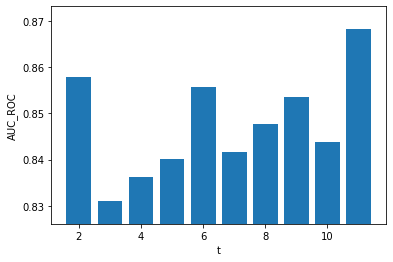

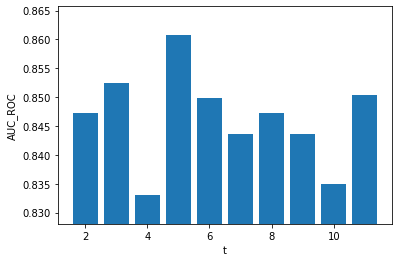

In [30]:
#computing auc_roc and precision for the random walk algorithms
auc_roc[rwwr] = nw.ROC_AUC(A, nw.random_walk_with_restart_link_prediction)
precision[rwwr] = nw.precision(A, nw.random_walk_with_restart_link_prediction)

roc_aucs = []
#testing many values of t and choosing the best
t_range = range(2, 12)
for t in t_range:
    roc_aucs.append(nw.ROC_AUC(A, nw.local_random_walk_link_prediction, [t]))

roc_aucs = np.array(roc_aucs)
plt.bar(t_range, roc_aucs )
plt.ylim([np.min(roc_aucs) - 0.005, np.max(roc_aucs) + 0.005])
plt.ylabel("AUC_ROC")
plt.xlabel("t")

#getting the best t
best_t = [t_range[np.argmax(np.array(roc_aucs))]]

#updating auc_roc for the algorithm
auc_roc[lrw] = nw.ROC_AUC(A, nw.local_random_walk_link_prediction, best_t)
#updating precision for the algorithm
precision[lrw] = nw.precision(A, nw.local_random_walk_link_prediction, best_t)

#trying again multiple values for t
roc_aucs = []
for t in t_range:
    roc_aucs.append(nw.ROC_AUC(A, nw.superposed_random_walk_link_prediction, [t]))

plt.figure()
roc_aucs = np.array(roc_aucs)
plt.bar(t_range, roc_aucs )
plt.ylabel("AUC_ROC")
plt.xlabel("t")
plt.ylim([np.min(roc_aucs)-0.005, np.max(roc_aucs)+0.005])

#selectin the best t
best_t = [t_range[np.argmax(np.array(roc_aucs))]]

#updating auc_roc for the algorithm
auc_roc[srw] = nw.ROC_AUC(A, nw.superposed_random_walk_link_prediction, best_t)
#updating precision for the algorithm
precision[srw] = nw.precision(A, nw.superposed_random_walk_link_prediction, best_t)

In [31]:
#getting auc_roc and precision for all the common neighbours algorithms except katz
auc_roc[cn] = nw.ROC_AUC(A, nw.common_neigh_link_prediction)
precision[cn] = nw.precision(A, nw.common_neigh_link_prediction)

auc_roc[aa] = nw.ROC_AUC(A, nw.adamic_adar_link_prediction)
precision[aa] = nw.precision(A, nw.adamic_adar_link_prediction)

auc_roc[ra] = nw.ROC_AUC(A, nw.resource_allocation_link_prediction)
precision[ra] = nw.precision(A, nw.resource_allocation_link_prediction)

In [32]:
#performing grid sort for katz in order to find out the best value of beta and l
l = range(2, 7)
beta = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001]
katz_res = np.zeros((len(l), len(beta)))
for i, l_i in enumerate(l):
    for j, b in enumerate(beta):
        roc_auc = nw.ROC_AUC(A, nw.katz_link_prediction, (l_i, b))
        katz_res[i, j] = roc_auc

Text(33.0, 0.5, '$l_{max}$')

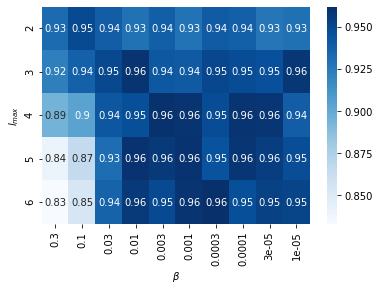

In [33]:
#plotting grid results
import seaborn as sns
ax = sns.heatmap(katz_res, cmap = "Blues", xticklabels=beta, yticklabels=l, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xlabel("$\\beta$")
ax.set_ylabel("$l_{max}$")

In [34]:
#finding the best beta and l
rows, cols = np.unravel_index(np.argmax(katz_res), katz_res.shape)
print(l[rows], beta[cols])

6 0.0003


In [35]:
#computing auc_roc and precision for katz
auc_roc["katz"] = nw.ROC_AUC(A, nw.katz_link_prediction, (l[rows], beta[cols]))
precision["katz"] = nw.precision(A, nw.katz_link_prediction, (l[rows], beta[cols]))

In [36]:
#getting a table with all the results
df = pd.DataFrame({"AUC_ROC":auc_roc, "Precision":precision})
df.head(10)

,AUC_ROC,Precision
Random walk with restart,0.975374,0.292343
Local random walk,0.840872,0.071926
Superposed random walk,0.829353,0.058005
Common neighbours,0.938389,0.197216
Adamic Adar,0.964562,0.243619
Resource Allocation,0.975685,0.385151
katz,0.938958,0.197216


In [37]:
df.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &   AUC\\_ROC &  Precision \\\\\n\\midrule\nRandom walk with restart &  0.975374 &   0.292343 \\\\\nLocal random walk        &  0.840872 &   0.071926 \\\\\nSuperposed random walk   &  0.829353 &   0.058005 \\\\\nCommon neighbours        &  0.938389 &   0.197216 \\\\\nAdamic Adar              &  0.964562 &   0.243619 \\\\\nResource Allocation      &  0.975685 &   0.385151 \\\\\nkatz                     &  0.938958 &   0.197216 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [38]:
#function used to find the next most likely link a character will make
def get_next_link_with_char(character, links, characters_id):
    i = 0
    while (characters_id[new_links[i][0]] != character) and (characters_id[new_links[i][1]] != character):
        i += 1
    return i 
    

In [39]:
#getting the prediction with the best algorithm for this dataset
S = nw.resource_allocation_link_prediction(A) 
new_links = nw.get_new_links(S, 2000)
max_len = 20

#printing the most likely new links
for link in new_links[:max_len]:
    print(characters_id[link[0]],"<->", characters_id[link[1]])


Daenerys Targaryen <-> Tyrion Lannister
Davos Seaworth <-> Sam Tarly
Arya Stark <-> Daenerys Targaryen
Catelyn Stark <-> Sam Tarly
Jaime Lannister <-> Lothar Frey
Gregor Clegane <-> Sansa Stark
Brienne <-> Tywin Lannister
Devan <-> Stannis Baratheon
Kevan Lannister <-> Robb Stark
Hosteen Frey <-> Raymund Frey
Barristan Selmy <-> Daario Naharis
Ami <-> Walder Frey
Davos Seaworth <-> Sansa Stark
Alyn Connington <-> Pate of Lancewood
Brandon Stark <-> Mance Raydar
Arya Stark <-> Bronn
Aemon Targaryen <-> Bowen Marsh
Edmure Tully <-> Sandor Clegane
Aegon <-> Aemon Targaryen
Ben Plumm <-> Simon Toyne


In [40]:
#printing some new links that might be interesting
i = get_next_link_with_char("Jon Snow", new_links, characters_id)
print("Next connection to Jon Snow")
print(characters_id[new_links[i][0]],"<->", characters_id[new_links[i][1]])
print()

i = get_next_link_with_char("Roose Bolton", new_links, characters_id)
print("Next connection to Roose")
print(characters_id[new_links[i][0]],"<->", characters_id[new_links[i][1]])
print()

i = get_next_link_with_char("Cersei Lannister", new_links, characters_id)
print("Next connection to Cersei Lannister")
print(characters_id[new_links[i][0]],"<->", characters_id[new_links[i][1]])

Next connection to Jon Snow
Aegon <-> Jon Snow

Next connection to Roose
Roose Bolton <-> Sansa Stark

Next connection to Cersei Lannister
Cersei Lannister <-> Roose Bolton
